# Setup
## Import and git root

In [972]:

import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git


from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import re

In [973]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway reference variables

In [974]:
bd.projects.set_current('SEE_LAB') 

# Exploration
## Brightway (pre-existing)

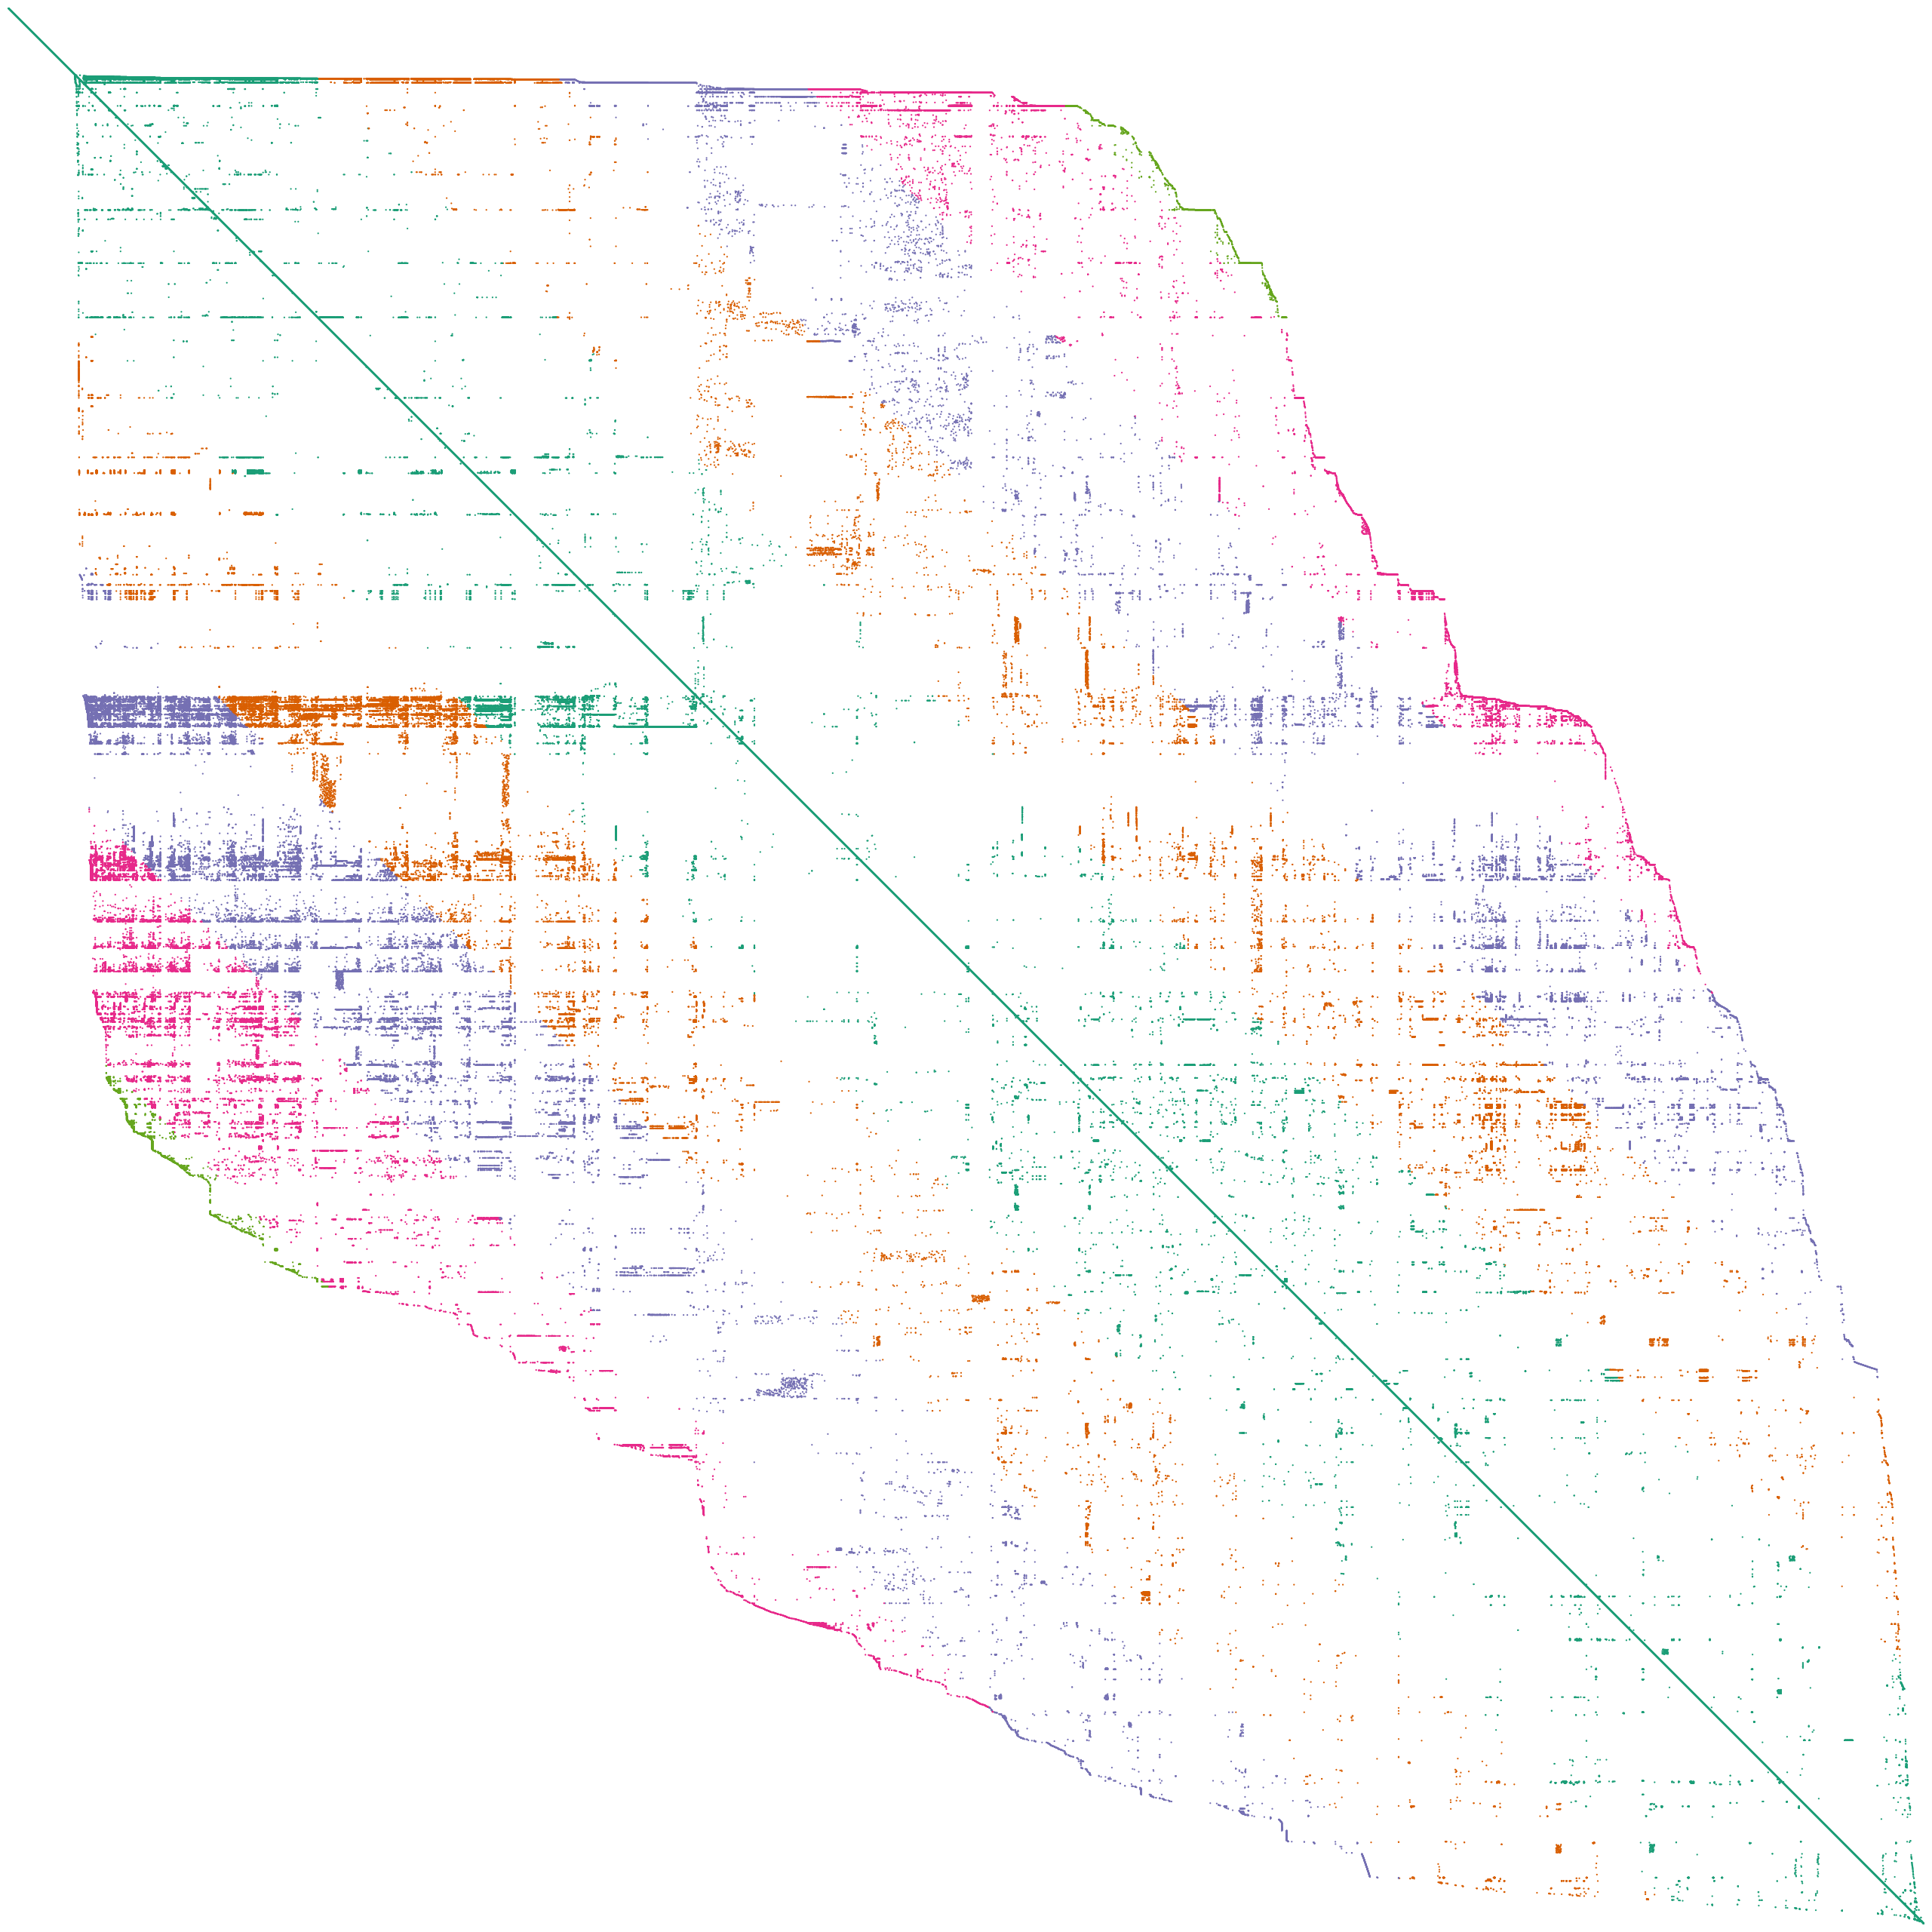

In [975]:
eidb = bd.Database("ecoinvent-3.11-cutoff")
eidb.graph_technosphere()


What this graphed technosphere means:

* Rox of pixels represent inputs to processes
* Columns of pixels represent outputs from processes
* (colors) represent the flow of materials, energy, or emissions between them.

In [976]:
random_act = eidb.random()
random_act.as_dict()

{'comment': 'This dataset represents the production of calcined clay, a pozzolanic material used in cement production.\nCalcined clay is produced by grinding and heating of natural clay between 500°C and 900°C. This thermal treatment (activation) converts crystalline clay materials to amorphous alumino silicates (Barger et al., 2001). When added to cement, amorphous silica reacts with calcium hydroxide formed during calcium silicate hydration from cement, forming C-S-H (hydrated calcium silicate). Secondary reactions may occur due to the reactive alumina content of calcined clay, forming also C-A-H (hydrated calcium aluminate) (Silva, 2007).\nThe addition of calcined clay to cement result in higher sulphate-resistance of the hydrated paste and in low permeability of the cementitious matrix, thus increasing the durability of cementitious products (Barger et al., 2001). In Brazil, calcined clay to be used in cement is standardized by ABNT NBR 12653.\nThis dataset is based on key process 

In [977]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'calcined clay production' (kilogram, BR, None) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 1.3 kilogram 'market for clay' (kilogram, RoW, None) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 0.025 kilowatt hour 'market group for electricity, medium voltage' (kilowatt hour, BR, None) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 0.0631240615384615 kilogram 'market for petroleum coke' (kilogram, GLO, None) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 0.20002437 kilogram 'Carbon dioxide, fossil' (kilogram, None, ('air',)) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 1.2309192e-06 kilogram 'Dinitrogen monoxide' (kilogram, None, ('air',)) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 6.154596e-06 kilogram 'Methane, fossil' (kilogram, None, ('air',)) to 'calcined clay production' (kilogram, BR, None)>
Exchange: 0.0003 cubic meter 'Water' (cubic meter, None, ('air',)) to 

In [978]:
[exc for exc in random_act.exchanges()][0].as_dict()


{'flow': '120d4874-c322-4173-988f-49841427a5c0',
 'type': 'production',
 'name': 'calcined clay',
 'classifications': {'CPC': ['15200: Gypsum; anhydrite; limestone flux; limestone and other calcareous stone, of a kind used for the manufacture of[…]']},
 'production volume': 223126380.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'dry mass': {'amount': 1.0, 'unit': 'kg'},
  'price': {'amount': 0.075,
   'comment': 'Calculated value based on data from United Nations Commodity Trade Statistics Database (comtrade.un.org). UN comtrade category: 250810 Bentonite. Year 2005. Using exchange rate of 1EURO = 1.209 USD. Average of price of import into 5 main markets (EU, US, JP, IN and CN).',
   'unit': 'EUR2005'},
  'water content': {'amount': 0.0, 'unit': 'dimension

## Original (trivial)
### Process Counts
#### Cleaning and Merging
First we'll look at all the technosphere processes

In [979]:
## Create a dictionary of all the country codes counts (from the technosphere activities) and convert to a dataframe
global_dict = defaultdict(int)
for act in eidb:
    cc_code = act['location']
    global_dict[cc_code] += 1

country_frame  = pd.DataFrame(list(global_dict.items()), columns=['Country', 'Process Count'])
country_frame

,Country,Process Count
0,Europe without Switzerland,620
1,DE,265
2,RoW,4673
3,GLO,4543
4,RER,2272
...,...,...
327,US-CA,2
328,IN-CH,1
329,ENTSO-E,3
330,Europe without Switzerland and Austria,2


We want to look at these as a map; this requires:
* shapefiles for each country region (eg a global shapefile with provinces included)
* a dictionary or map to get from each country code to each shapefile 

Luckily, the database overview has a geographies sheet to match what this includes. We merge this now. 

In [980]:
geographies = pd.read_excel(f"{root}/Data/Database-Overview-for-ecoinvent-v3.10_29.04.24.xlsx", sheet_name="Geographies")
country_frame = pd.merge(
    left=country_frame,
    right=geographies,
    how='inner',
    left_on='Country',
    right_on='Shortname'
)

## Clean the frame a bit further. 
country_frame.drop(columns='Country', inplace=True)
country_frame.sort_values(by='Process Count', ascending=False).head(10)


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
2,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN
3,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...
15,2710,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN
4,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
0,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
26,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...
5,420,868a66d1-7428-4ba2-9125-253b07afc119,"Canada, Québec",CA-QC,53.390446,-71.755869,Province or State,NaN
14,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...
27,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...
19,297,12b21766-7d7e-11de-9ae2-0019e336be3a,South Africa,ZA,-30.558000,23.121000,Country,NaN


Explore the distribution a little 

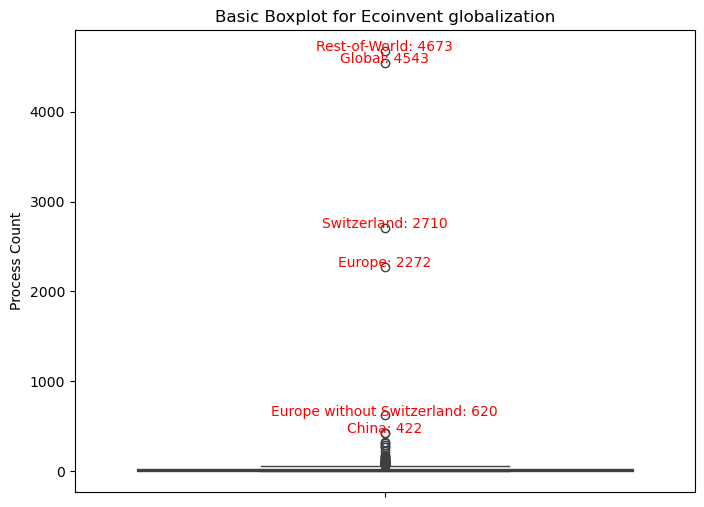

In [981]:
top5 = country_frame.sort_values(by='Process Count', ascending=False).head(6).copy()

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=country_frame, y='Process Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Process Count'], f"{outlier['Name']}: {outlier['Process Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

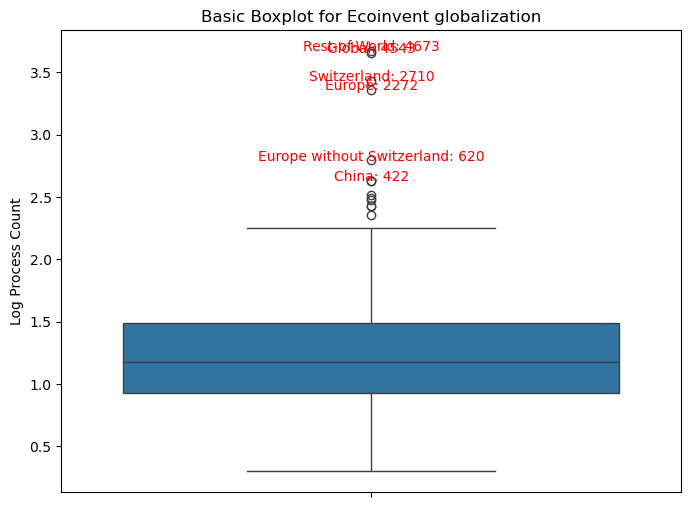

In [982]:
plt.figure(figsize=(8, 6))
country_frame['Log Process Count'] = np.log10(country_frame['Process Count'] + 1) 
top5 = country_frame.sort_values(by='Process Count', ascending=False).head(6).copy()

ax = sns.boxplot(data=country_frame, y='Log Process Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Log Process Count'], f"{outlier['Name']}: {outlier['Process Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

Note that:

* Global means global average production -- it **always** means that.
* Rest of World (RoW) means all the activites NOT explicitly locally defined. For example, if you have Switzerland and USA, than RoW means the global average minus those countries (from both numerator and denominator). Importantly, this means that RoW is **different** for every process (because they have different amounts of regional data).
* RoW values are not included if the regional values leave <.5% of the global production volume.

This means that in order to map RoW accurately we'd have to 'subtract' the process values we have (for that process). Luckily, at present, this seems like it wouldn't be that useful.
Source: https://support.ecoinvent.org/geographies




Note also that there are lots of non-country codes in here. Either like RoW on a smaller scale (eg, Europe without Switzerland), or other micro-regions defined by ecoquery or other organizations. For example, a regional electrical grid. In an effort to fix this, we'll have to do some parsing to try to get all the contained geographies in a machine readable format (here, ISO two letter country codes).

In [983]:
## functions for processing df rows
def get_basename(text):
    text = str(text)
    if len(text) == 2:
        return text
    
    # get the country code from the name, if it makes sense to (written in the XX- format, eg, US-CA for Caliifornia)
    match = re.search(r"..-", text) 
    return match.group(0)[:2] if match else None

def get_basenames(text):
    text = str(text)
    return [get_basename(item.strip()) for item in text.split(";")]

## create a column from the basename, and another  that lists all the contained geogrpahies in our ISO indexable format
country_frame['base_name'] = country_frame['Shortname'].apply(get_basename)
country_frame.sort_values(by='Process Count', ascending=False).head(10)


country_frame['Contained_Geographies_List'] = country_frame['Contained and Overlapping Geographies'].apply(get_basenames)


## check out the frame, looking at the largest once that have a contained geography
country_frame.dropna(subset=['Contained and Overlapping Geographies']).sort_values(by='Process Count', ascending=False).head(25)


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,Log Process Count,base_name,Contained_Geographies_List
3,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,3.657438,None,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,..."
4,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,3.356599,None,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N..."
0,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,2.793092,None,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N..."
26,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,2.626340,CN,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,..."
14,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,2.514548,US,"[None, None, US, US, US, US, US, US, US, US, U..."
27,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,2.495544,BR,"[BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, B..."
43,268,0e6a7860-7d7e-11de-9ae2-0019e336be3a,India,IN,21.000000,78.500000,Country,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...,2.429752,IN,"[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, I..."
37,170,12ea642c-7d7e-11de-9ae2-0019e336be3a,Spain,ES,40.227000,-3.649000,Country,Canary Islands,2.232996,ES,[None]
12,117,12143bfe-7d7e-11de-9ae2-0019e336be3a,Russia,RU,61.847380,97.037378,Country,Asia without China; Europe without Austria; Eu...,2.071882,RU,"[None, None, None, None, None, None, None, Non..."
34,107,0fecb5e8-7e2a-11de-9820-0019e336be3a,Northern America,RNA,58.710600,-91.968294,UN Subregion,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,2.033424,None,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,..."


There are two categories of contained geography here:
* Those that **obscure** locality. For example, Europe except Switzerland is basically just Europe. It makes sense in opposition to Switzerland, but I don't think we should count it as local data for all the sub regions -- that is, add the process count to all the countries included. Instead, we'll just add it to the Europe category for the 
* Those that **enhance** locality. For example. All the regional electricity grids, such as India, Eastern grid. We need to bear these in mind when we are doing heatmap data or trying to subdivide countries. Otherwise, we can just take the sum and add it to the country as a whole to get a good indication of **national** level process counts.

In [984]:
## if the list column is all for sub-localities of the same place, we can just say that it's all for that place
def update_single_val(row):
    list_vals = row['Contained_Geographies_List']
    single_val = row['base_name']
    
    if single_val is None and len(set(list_vals)) == 1:
        row['single_col'] = list_vals[0]  # Update single_val to the value in the list
    return row

country_frame = country_frame.apply(update_single_val, axis=1)
country_frame.dropna(subset=['Contained and Overlapping Geographies']).sort_values(by='Process Count', ascending=False).head(25)


,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
3,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN
4,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN
0,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN
26,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,...",Country,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,33.420000,2.626340,106.514000,China,422,CN,CN,NaN
14,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN
27,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,"[BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, B...",Country,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,-10.772000,2.495544,-53.089000,Brazil,312,BR,BR,NaN
43,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...,"[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, I...",Country,0e6a7860-7d7e-11de-9ae2-0019e336be3a,21.000000,2.429752,78.500000,India,268,IN,IN,NaN
37,Canary Islands,[None],Country,12ea642c-7d7e-11de-9ae2-0019e336be3a,40.227000,2.232996,-3.649000,Spain,170,ES,ES,NaN
12,Asia without China; Europe without Austria; Eu...,"[None, None, None, None, None, None, None, Non...",Country,12143bfe-7d7e-11de-9ae2-0019e336be3a,61.847380,2.071882,97.037378,Russia,117,RU,RU,NaN
34,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN


In [985]:
cont_codes = pd.read_csv(f"{root}/Data/indexing_csvs/country-and-continent-codes-list.csv")
cont_codes

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0
...,...,...,...,...,...,...
257,Africa,AF,"Zambia, Republic of",ZM,ZMB,894.0
258,Oceania,OC,Disputed Territory,XX,NaN,NaN
259,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN,NaN
260,Asia,AS,United Nations Neutral Zone,XD,NaN,NaN


In [986]:
country_frame[country_frame['Name'] == 'Europe']

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
4,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN


This looks good, so now we merge with an ISO sheet for continent and region indexing.

In [987]:
## First we merge with the named Continents directly
cont_codes = pd.read_csv(f"{root}/Data/indexing_csvs/country-and-continent-codes-list.csv")
conts_only = cont_codes['Continent_Name'].value_counts().reset_index().drop(columns='count')
cont_frame = pd.merge(
    left=country_frame,
    right=conts_only,
    left_on='Name',
    right_on='Continent_Name',
    how='inner'
)
cont_frame

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name
0,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,Europe
1,AS; AU; AU-ACT; AU-JBT; AU-NSW; AU-NT; AU-QLD;...,"[AS, AU, AU, AU, AU, AU, AU, AU, AU, AU, AU, C...",UN Region,9232290c-e62b-11de-ba56-0019e336be3a,-25.282887,1.322219,136.406721,Oceania,20,UN-OCEANIA,UN,NaN,Oceania
2,AE; AF; Akrotiri; AM; Asia without China; AZ; ...,"[AE, AF, None, AM, None, AZ, BD, BH, BN, BT, N...",ecoinvent Region,19c7cdd2-e590-11de-9dfe-0019e336be3a,45.201180,1.544068,96.075924,Asia,34,RAS,None,NaN,Asia
3,AO; BF; BI; BJ; BW; CD; CF; CG; CM; CV; DJ; DZ...,"[AO, BF, BI, BJ, BW, CD, CF, CG, CM, CV, DJ, D...",UN Region,2f693dc6-7e28-11de-9820-0019e336be3a,6.417882,1.000000,18.287021,Africa,9,RAF,None,NaN,Africa


In [988]:
## Now we merge with the basenames, dropping those that don't have a basename
country_frame_redux = pd.merge(
    left=country_frame.dropna(subset=['base_name']),
    right=cont_codes,
    left_on='base_name',
    right_on='Two_Letter_Country_Code',
    how='left'
)
country_frame_redux.sort_values(by='Process Count', ascending=False).head(4)

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
12,NaN,[None],Country,131278d6-7d7e-11de-9ae2-0019e336be3a,46.861000,3.433130,7.908000,Switzerland,2710,CH,CH,NaN,Europe,EU,"Switzerland, Swiss Confederation",CH,CHE,756.0
23,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,...",Country,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,33.420000,2.626340,106.514000,China,422,CN,CN,NaN,Asia,AS,"China, People's Republic of",CN,CHN,156.0
1,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,CA,NaN,North America,NaN,Canada,CA,CAN,124.0
11,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN,North America,NaN,United States of America,US,USA,840.0


In [989]:
## Get those countries who don't connect and remove them.

unlabeled = country_frame[country_frame['base_name'].isna()].sort_values(by='Process Count', ascending=False)
unlabeled[unlabeled['Process Count'] > 15]

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
2,NaN,[None],ecoinvent Custom Area,7846b897-7c04-4f9f-b607-2b83fcd9a74c,NaN,3.669689,NaN,Rest-of-World,4673,RoW,None,NaN
3,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN
4,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN
0,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN
34,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN
63,NaN,[None],ecoinvent Custom Area,81e54bf8-5993-5b5b-bc50-6978cab0c51f,NaN,1.806180,NaN,Rest of Europe,63,RoE,None,NaN
141,AE; AF; Akrotiri; AM; Asia without China; AZ; ...,"[AE, AF, None, AM, None, AZ, BD, BH, BN, BT, N...",ecoinvent Region,19c7cdd2-e590-11de-9dfe-0019e336be3a,45.201180,1.544068,96.075924,Asia,34,RAS,None,NaN
125,AG; AI; AR; AW; BB; BL; BO; BQ; BR; BR-AC; BR-...,"[AG, AI, AR, AW, BB, BL, BO, BQ, BR, BR, BR, B...",UN Subregion,09db3260-7e2a-11de-9820-0019e336be3a,-10.119415,1.505150,-65.624398,Latin America and the Caribbean,31,RLA,None,NaN
246,Canary Islands; CENTREL; DE; ES; Europe withou...,"[None, None, DE, ES, None, None, FR, None, GB,...",Aluminium Industry,b7fcfda9-0add-49aa-87d4-d60f3bda4283,NaN,1.505150,NaN,"IAI Area, EU27 & EFTA",31,"IAI Area, EU27 & EFTA",None,NaN
193,CA-AB; CA-BC; CA-MB; Canada without Alberta; C...,"[CA, CA, CA, None, None, CA, CA, CA, CA, CA, C...",ecoinvent Custom Area,a4d7d7fd-94ae-4f44-91ba-53cd7f79bac4,NaN,1.230449,NaN,Canada without Quebec,16,Canada without Quebec,None,NaN


In [990]:
## Some of them we have to just label by hand
mappings = {
    'Rest-of-World': 'Global',
    'global': 'Global',
    'Europe without Switzerland': 'Europe',
    'Canada without Quebec': 'North America',
    'Rest of Europe': 'Europe',
    'Northern America': 'North America',
    'Latin America and the Caribbean': 'South America'

}

unlabeled['Continent_Name'] = unlabeled['Name'].map(mappings)

In [991]:
country_frame_merged_cont = pd.concat([unlabeled, country_frame_redux, cont_frame], axis=0, ignore_index=True)

print(country_frame.shape, country_frame_merged_cont.shape)

(331, 12) (342, 18)


In [992]:
country_frame_merged_cont

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,NaN,[None],ecoinvent Custom Area,7846b897-7c04-4f9f-b607-2b83fcd9a74c,NaN,3.669689,NaN,Rest-of-World,4673,RoW,None,NaN,Global,NaN,NaN,NaN,NaN,NaN
1,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN,Europe,NaN,NaN,NaN,NaN,NaN
4,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN,North America,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,[None],Country,129718da-7d7e-11de-9ae2-0019e336be3a,-1.998000,0.301030,29.917000,Rwanda,1,RW,RW,NaN,Africa,AF,"Rwanda, Republic of",RW,RWA,646.0
338,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,Europe,NaN,NaN,NaN,NaN,NaN
339,AS; AU; AU-ACT; AU-JBT; AU-NSW; AU-NT; AU-QLD;...,"[AS, AU, AU, AU, AU, AU, AU, AU, AU, AU, AU, C...",UN Region,9232290c-e62b-11de-ba56-0019e336be3a,-25.282887,1.322219,136.406721,Oceania,20,UN-OCEANIA,UN,NaN,Oceania,NaN,NaN,NaN,NaN,NaN
340,AE; AF; Akrotiri; AM; Asia without China; AZ; ...,"[AE, AF, None, AM, None, AZ, BD, BH, BN, BT, N...",ecoinvent Region,19c7cdd2-e590-11de-9dfe-0019e336be3a,45.201180,1.544068,96.075924,Asia,34,RAS,None,NaN,Asia,NaN,NaN,NaN,NaN,NaN


In [993]:
country_frame_merged_cont['Two_Letter_Country_Code'].value_counts()

Two_Letter_Country_Code
CN    40
IN    39
BR    32
US    26
CA    14
      ..
HK     1
NI     1
CW     1
SO     1
RW     1
Name: count, Length: 144, dtype: int64

In [994]:
country_frame_combined.sort_values(by='Process Count_summed', ascending=False)

,Two_Letter_Country_Code,Process Count_summed,Log Process Count_summed
22,CH,2710.0,3.432969
16,BR,994.0,2.997386
26,CN,983.0,2.992554
19,CA,845.0,2.926857
135,US,643.0,2.808211
...,...,...,...
122,SS,6.0,0.778151
140,YE,6.0,0.778151
103,PG,5.0,0.698970
121,SO,3.0,0.477121


#### Figures

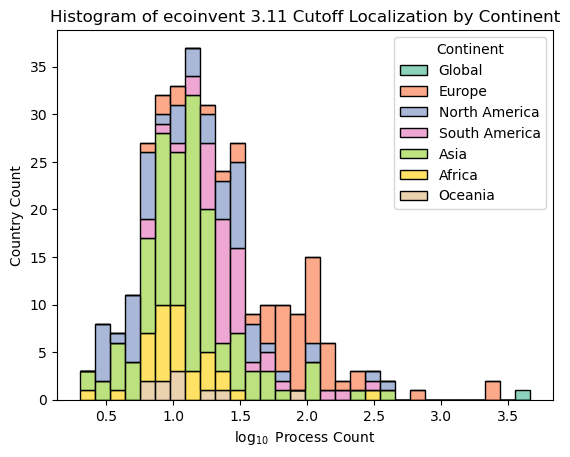

In [995]:
# Stacked histogram with hue for coloring
sns.histplot(
    data=country_frame_merged_cont,
    x=country_frame_merged_cont['Log Process Count'],  # Log-transform
    hue='Continent_Name',                                 
    multiple='stack',                                 
    bins=30,
    palette='Set2'                                  
)

# Labels and title
plt.xlabel(r"$\log_{10}$ Process Count")
plt.ylabel("Country Count")
plt.title("Histogram of ecoinvent 3.11 Cutoff Localization by Continent")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 


plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/ecoinvent_localization_hist.png", bbox_inches='tight')

plt.show()

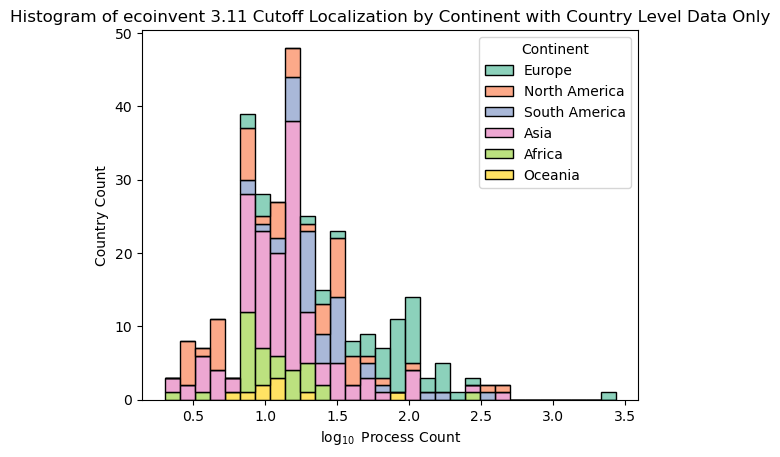

In [996]:
# Stacked histogram with hue for coloring
sns.histplot(
    data=country_frame_redux,
    x=country_frame_redux['Log Process Count'],  # Log-transform
    hue='Continent_Name',                                 
    multiple='stack',                                 
    bins=30,
    palette='Set2'                                  
)

# Labels and title
plt.xlabel(r"$\log_{10}$ Process Count")
plt.ylabel("Country Count")
plt.title("Histogram of ecoinvent 3.11 Cutoff Localization by Continent with Country Level Data Only")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 

plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/ecoinvent_localization_hist_country_only.png", bbox_inches='tight')

plt.show()

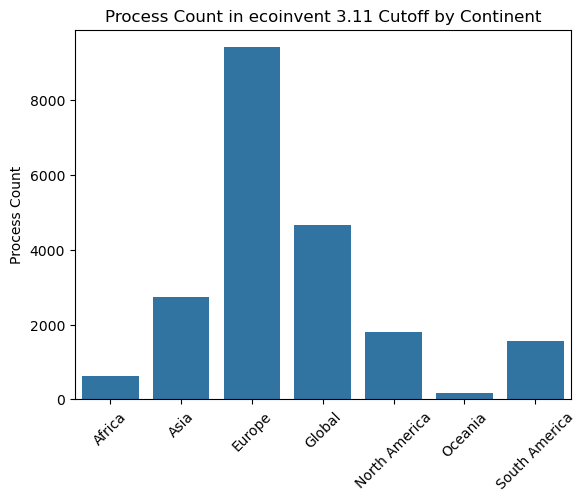

In [997]:
continent_frame = country_frame_merged_cont.groupby(country_frame_merged_cont['Continent_Name'])['Process Count'].sum().reset_index()
sns.barplot(data=continent_frame, x='Continent_Name', y='Process Count')
plt.xlabel("")
plt.title("Process Count in ecoinvent 3.11 Cutoff by Continent")
plt.xticks(rotation=45)
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/Process_count_by_continent.png")
plt.show()

### Economic Plots

In [998]:
gdp_frame = pd.read_csv(f"{root}/Data/indexing_csvs/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_88.csv")

In order to make the gdp make sense we need to conglomerate all the territory process counts

In [999]:
# Grouping by 'Two_Letter_Country_Code' and summing 'Process Count'
country_frame_merged_cont_grouped = (
    country_frame_merged_cont
    .groupby('Two_Letter_Country_Code', as_index=False)['Process Count']
    .sum()
)

# Merging the grouped sums back to the original DataFrame
country_frame_merged_cont_grouped = country_frame_merged_cont.merge(
    country_frame_merged_cont_grouped[['Two_Letter_Country_Code', 'Process Count']], 
    on='Two_Letter_Country_Code', 
    how='left', 
    suffixes=('', '_summed')
)

# Creating 'Log Process Count' as the log10 of the summed 'Process Count'
country_frame_merged_cont_grouped['Log Process Count_summed'] = np.log10(
    country_frame_merged_cont_grouped['Process Count_summed']
)

country_frame_combined = country_frame_merged_cont_grouped.groupby('Two_Letter_Country_Code', as_index=False).agg({
    'Process Count_summed': 'mean',  # Summing 'Process Count'
    'Log Process Count_summed': 'mean'  # Optionally, taking the mean of 'Log Process Count' or another aggregation
})

country_frame_merged_cont_grouped = country_frame_merged_cont_grouped.drop_duplicates(
    subset='Two_Letter_Country_Code', 
    keep='first'
)

In [1000]:
country_frame_merged_cont_grouped.sort_values(by='Process Count_summed', ascending=False)

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number,Process Count_summed,Log Process Count_summed
43,NaN,[None],Country,131278d6-7d7e-11de-9ae2-0019e336be3a,46.861000,3.433130,7.908000,Switzerland,2710,CH,CH,NaN,Europe,EU,"Switzerland, Swiss Confederation",CH,CHE,756.0,2710.0,3.432969
38,BR-AL; BR-BA; BR-CE; BR-MA; BR-PB; BR-PE; BR-P...,"[BR, BR, BR, BR, BR, BR, BR, BR, BR]",Electricity Grid,3ece4ff8-55ae-40b2-baea-0d2bf2034fbf,NaN,1.301030,NaN,"Brazil, North-eastern grid",19,BR-North-eastern grid,BR,NaN,South America,SA,"Brazil, Federative Republic of",BR,BRA,76.0,994.0,2.997386
49,NaN,[None],Electricity Grid,094ba255-b84b-5fbd-8c8a-75547f362075,NaN,0.954243,NaN,"China, Southwest Grid",8,CN-SWG,CN,NaN,Asia,AS,"China, People's Republic of",CN,CHN,156.0,983.0,2.992554
32,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,CA,NaN,North America,NaN,Canada,CA,CAN,124.0,845.0,2.926857
42,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN,North America,NaN,United States of America,US,USA,840.0,643.0,2.808211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,NaN,[None],Country,c08de0ce-64e7-4efb-a37f-8df754c262c8,NaN,0.845098,NaN,Curaçao,6,CW,CW,NaN,North America,NaN,Curaçao,CW,CUW,531.0,6.0,0.778151
161,NaN,[None],Country,11663ae0-7d7e-11de-9ae2-0019e336be3a,-5.949000,0.778151,143.459000,Papua New Guinea,5,PG,PG,NaN,Oceania,OC,"Papua New Guinea, Independent State of",PG,PNG,598.0,5.0,0.698970
336,AD; AT; AX; BA; BALTSO; BE; BG; Canary Islands...,"[AD, AT, AX, BA, None, BE, BG, None, None, CH,...",Electricity Grid,f87aa98c-d820-11de-a736-0019e336be3a,NaN,0.602060,NaN,European Network of Transmission Systems Opera...,3,ENTSO-E,SO,NaN,Africa,AF,"Somalia, Somali Republic",SO,SOM,706.0,3.0,0.477121
337,NaN,[None],Country,129718da-7d7e-11de-9ae2-0019e336be3a,-1.998000,0.301030,29.917000,Rwanda,1,RW,RW,NaN,Africa,AF,"Rwanda, Republic of",RW,RWA,646.0,1.0,0.000000


In [1001]:
merged_gdp = pd.merge(
    left=country_frame_merged_cont_grouped,
    right=gdp_frame,
    left_on='Three_Letter_Country_Code',
    right_on='Country Code',
    how='inner',
)

merged_gdp['log_gdp'] = np.log10(merged_gdp['2022'])
merged_gdp


,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,...,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68,log_gdp
0,NaN,[None],Country,0e0e1020-7d7e-11de-9ae2-0019e336be3a,51.110000,2.424882,9.851000,Germany,265,DE,...,3.537784e+12,3.763092e+12,4.052008e+12,3.957208e+12,3.940143e+12,4.348297e+12,4.163596e+12,4.525704e+12,NaN,12.619469
1,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,...,1.527995e+12,1.649266e+12,1.725329e+12,1.743725e+12,1.655685e+12,2.007472e+12,2.161483e+12,2.142471e+12,NaN,12.334752
2,NaN,[None],Country,13725fee-7d7e-11de-9ae2-0019e336be3a,53.000000,2.193125,-1.600000,United Kingdom,155,GB,...,2.689107e+12,2.680148e+12,2.871340e+12,2.851407e+12,2.696778e+12,3.143323e+12,3.114042e+12,3.380855e+12,NaN,12.493325
3,Europe without NORDEL (NCPA); NORDEL; UCTE; UC...,"[None, None, None, None, None, None]",Country,0cf950f0-7d7e-11de-9ae2-0019e336be3a,56.058000,1.929419,9.264000,Denmark,84,DK,...,3.121818e+11,3.316106e+11,3.552934e+11,3.454015e+11,3.556310e+11,4.083782e+11,4.019456e+11,4.070919e+11,NaN,11.604167
4,NaN,[None],Country,115c647a-7d7e-11de-9ae2-0019e336be3a,40.309000,1.924279,-8.058000,Portugal,83,PT,...,2.063054e+11,2.208630e+11,2.420929e+11,2.401160e+11,2.296188e+11,2.560559e+11,2.568987e+11,2.891143e+11,NaN,11.409762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,NaN,[None],Country,0ff7be54-7d7e-11de-9ae2-0019e336be3a,22.423000,0.903090,114.129000,Hong Kong S.A.R.,7,HK,...,3.208603e+11,3.412733e+11,3.617311e+11,3.630745e+11,3.449431e+11,3.689542e+11,3.586811e+11,3.808122e+11,NaN,11.554708
139,NaN,[None],Country,111cdba2-7d7e-11de-9ae2-0019e336be3a,12.840000,1.041393,-85.034000,Nicaragua,10,NI,...,1.328610e+10,1.378592e+10,1.302523e+10,1.269903e+10,1.268157e+10,1.414406e+10,1.564990e+10,1.782922e+10,NaN,10.194511
140,NaN,[None],Country,c08de0ce-64e7-4efb-a37f-8df754c262c8,NaN,0.845098,NaN,Curaçao,6,CW,...,3.024690e+09,3.033433e+09,3.046365e+09,3.026124e+09,2.534328e+09,2.739608e+09,3.075181e+09,3.281419e+09,NaN,9.487871
141,AD; AT; AX; BA; BALTSO; BE; BG; Canary Islands...,"[AD, AT, AX, BA, None, BE, BG, None, None, CH,...",Electricity Grid,f87aa98c-d820-11de-a736-0019e336be3a,NaN,0.602060,NaN,European Network of Transmission Systems Opera...,3,ENTSO-E,...,6.613743e+09,7.621502e+09,7.873441e+09,8.655024e+09,8.628394e+09,9.483997e+09,1.020277e+10,1.096852e+10,NaN,10.008718


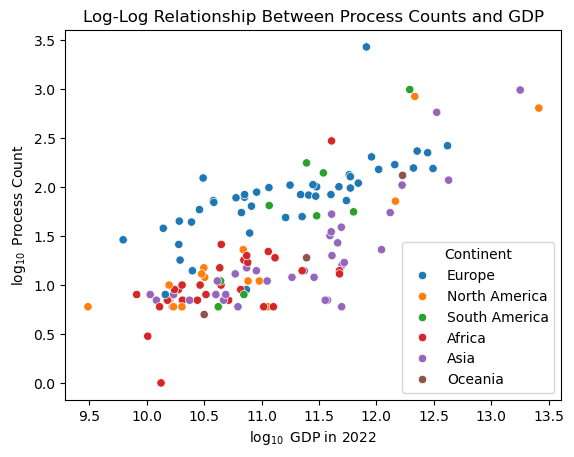

In [1002]:
sns.scatterplot(data=merged_gdp, y='Log Process Count_summed', x='log_gdp', hue='Continent_Name')
plt.title("Log-Log Relationship Between Process Counts and GDP")
plt.ylabel(r"$\log_{10}$ Process Count")
plt.xlabel(r"$\log_{10}$ GDP in 2022")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/GDP_Process_Scatterplot.png")
plt.show()


### Geomapping

#### Load in Shapefiles

In [1003]:
states = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_states_provinces_all/ne_10m_admin_1_states_provinces.shp")
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [1004]:
countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
# for col in countries.columns:
#     print(col)
countries[countries['ISO_A2'] == 'US']


## Using this commented code we figure out that norway and france, as well as some dispute countries, don't have ISO codes. As we'll use these for merging, 
## we just manually fix them. 
# problem_rows = countries[countries['ISO_A2'] == '-99']
# print(problem_rows[['NAME', 'ISO_A2', 'ISO_A3']])

fixes = {
    'France': {'ISO_A2': 'FR', 'ISO_A3': 'FRA'},
    'Norway': {'ISO_A2': 'NO', 'ISO_A3': 'NOR'},
    'Kosovo': {'ISO_A2': 'XK', 'ISO_A3': 'XKX'},       
    'Somaliland': {'ISO_A2': 'SO', 'ISO_A3': 'SOL'},   
}

for name, codes in fixes.items():
    countries.loc[countries['NAME'] == name, ['ISO_A2', 'ISO_A3']] = codes['ISO_A2'], codes['ISO_A3']

In [1005]:

## get all the non-country territories 
matched_territories = pd.merge(
    left = country_frame_merged_cont,
    right = states,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_3166_2'
)

# countries_left = country_frame_merged_cont[~country_frame_merged_cont['Shortname'].isin(matched_territories['Shortname'])]
# countries_left

## get all the country-level territories
matched_countries = pd.merge(
    left = country_frame_merged_cont,
    right = countries,
    how = 'inner',
    left_on = 'Two_Letter_Country_Code',
    right_on = 'ISO_A2'
)

# ## for a final frame, un-localize the territory level processes to the country-level
# grouped = matched_territories.groupby(matched_territories['Shortname'].str[:2])['Process Count'].sum().reset_index() ## add the 
# matched_added = pd.merge(
#     matched_countries, grouped, on='Shortname', how='outer', suffixes=('_df1', '_df2'))
# matched_added
# matched_added['Process Count'] = matched_added['Process Count_df1'].fillna(0) + matched_added['Process Count_df2'].fillna(0)


## for a final frame, un-localize the territory level processes to the country-level using the model we used for GDP
country_frame_merged_cont_grouped_gdf = pd.merge(
    left = country_frame_merged_cont_grouped,
    right = countries,
    how = 'inner',
    left_on='Two_Letter_Country_Code',
    right_on='ISO_A2'
)


In [1006]:
grouped.head(10)

,Shortname,Process Count
0,AU,62
1,BR,604
2,CA,713
3,CN,475
4,IN,256
5,US,63


In [1007]:
## set up a dictionary, convert everything to coordinates
frames = {
    "country-level processes in ecoinvent 3.11 cutoff technosphere" : matched_countries,
    "territory-level processes in ecoinvent 3.11 cutoff technosphere" : matched_territories,
    # "all processes in ecoinvent 3.11 cutoff technosphere, with territory specific rolled into countries" : matched_added,
    "all processes in ecoinvent 3.11 cutoff technosphere, with territory specific rolled into countries": country_frame_merged_cont_grouped_gdf
}

for name, frame in frames.items():
    frame = gpd.GeoDataFrame(frame, geometry='geometry')
    frame.set_crs('EPSG:4326', allow_override=True, inplace=True)
    frames[name] = frame

#### Geographic Heatmaps

In [1008]:
def plot_heatmap_frame(frame, ax, col='Process Count'):
    # Get colors and plot them
    ax.axis("off")
    cm = mpl.colormaps.get_cmap("YlOrRd")
    norm = mpl.colors.LogNorm(vmin=1, vmax=10**4)

    ## Dynamic Norming (left for posterity)
    # norm = mpl.colors.LogNorm(vmin=frame['Process Count'].min(), vmax=frame['Process Count'].max())

    print(col)
    frame.plot(column=col, norm=norm, cmap=cm, ax=ax,
               edgecolor='black',
                linewidth = 0.3 )
    
    countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
    countries.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.2)

    
    ## Dynamic Colorbar 
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm._A = []  
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.0)
    cbar.set_label('Process Count')  

Process Count
Process Count
Process Count_summed


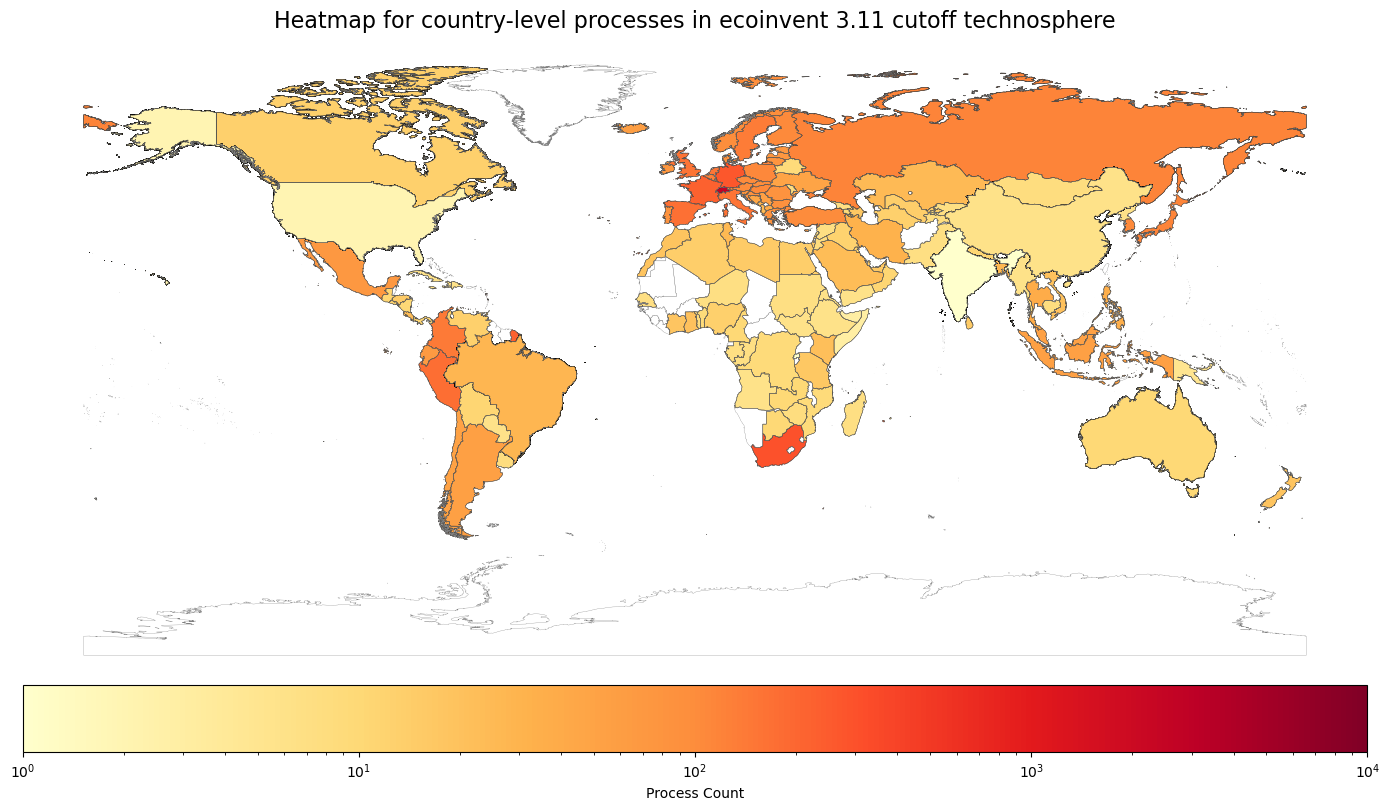

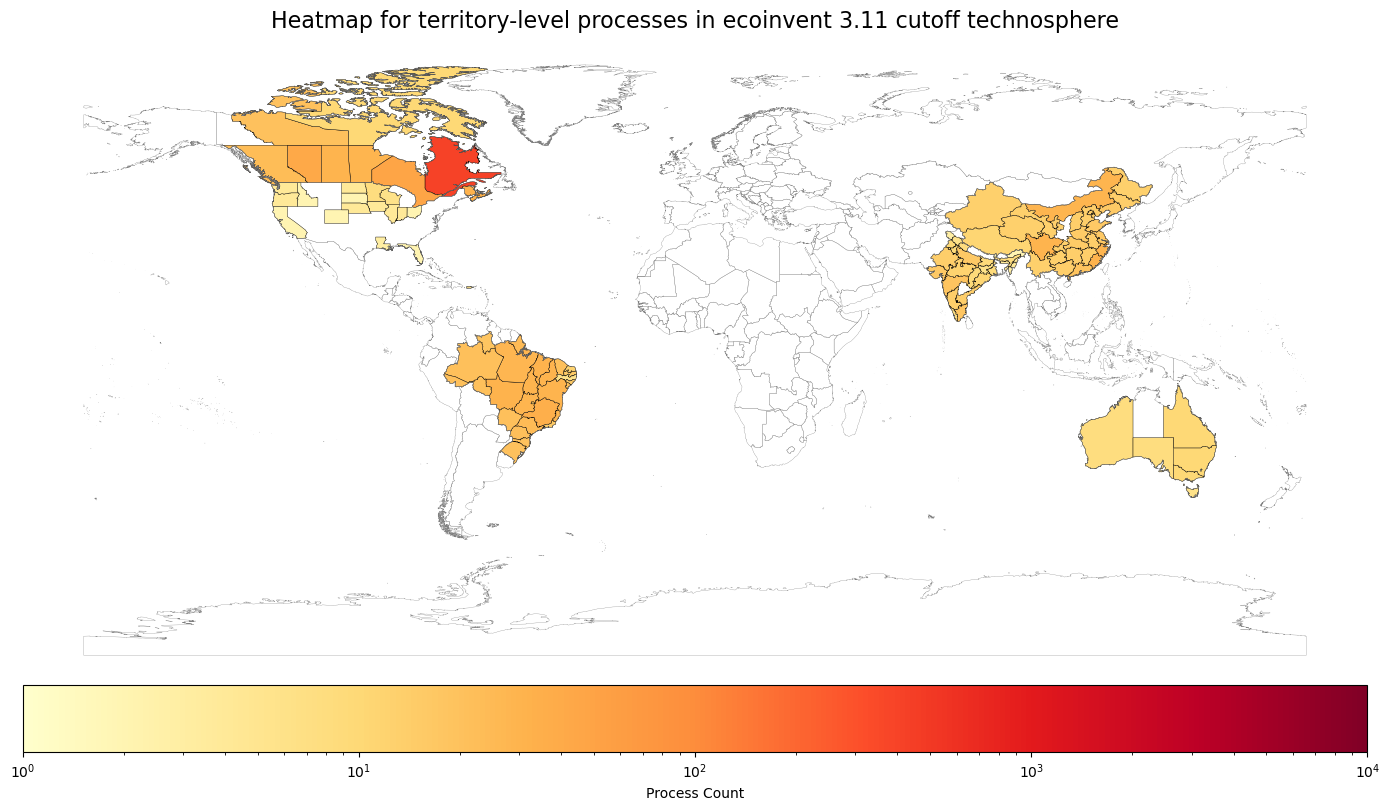

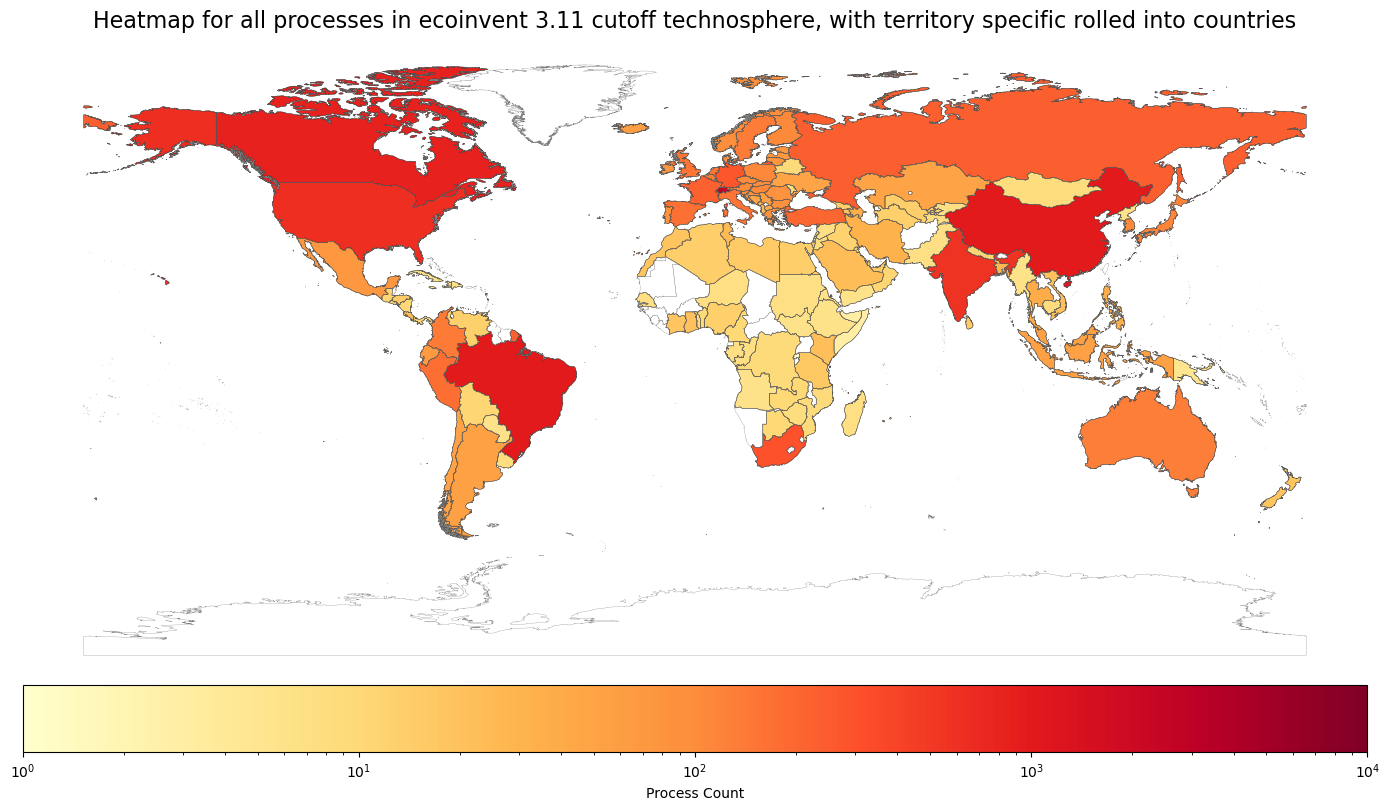

In [1009]:
i = 0
for name, frame in frames.items():
        if i < 2:
                col = "Process Count" 
        else:
                col="Process Count_summed"
        fig, ax = plt.subplots(1, figsize=(14, 16))
        plot_heatmap_frame(frame, ax, col=col)
        plt.title(f"Heatmap for {name}", fontsize=16)
        plt.tight_layout() 
        plt.savefig(f"{root}/Figures/Basic_Viz/Heatmaps/{name}.png",  bbox_inches='tight')
        i += 1
